# Time series analysis with R 

The objective of this mini-project is to select the most important features in a dataset, aggregate and transform them into time series to obtain some information like:

- Is there a trend?
- Is there a seasonal pattern?
- Are the time series stationary?

For this task, we will use some R libraries namely: Tidyverse (data structures), Lubridate (dates and times), Forecast (time series), and MLmetrics (evaluation).

In [1]:
# Load necessary libraries
library(tidyverse)
library(lubridate)
library(forecast)
library(MLmetrics)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.3     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union




In [2]:
# Load dataset from CSV file
dat <- read.csv('./data/Activities.csv',header = T)

Before start, let's get acquainted with the dataset.

In [3]:
# Print the first ten rows of the dataset with its headers
head(dat,10); sprintf("% s rows x % s columns", nrow(dat),  ncol(dat))

,activityId,uuidMsb,uuidLsb,name,activityType,userProfileId,timeZoneId,beginTimestamp,eventTypeId,rule,...,maxFtp,workoutId,decoDive,parentId,avgVerticalSpeed,maxDepth,avgDepth,surfaceInterval,floorsDescended,bottomTime
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<chr>,...,<int>,<dbl>,<lgl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>
1,5570974040,3.695224e+18,-7.098507e+18,En piscine,lap_swimming,1141258,124,1.600700e+12,9,public,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,5566524321,-5.212790e+18,-8.140623e+18,Vienna Cyclisme,cycling,1141258,124,1.600602e+12,9,public,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,5561266034,1.271356e+18,-5.522844e+18,Korneuburg Cyclisme,cycling,1141258,124,1.600523e+12,9,public,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,5555881653,-2.923938e+18,-4.676832e+18,Vienna Course,running,1141258,124,1.600439e+12,9,public,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,5551811953,7.859043e+18,-7.909532e+18,Zwift - London,virtual_ride,1141258,124,1.600362e+12,9,public,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,5551052200,-9.554086e+17,-6.866435e+18,En piscine,lap_swimming,1141258,124,1.600353e+12,9,public,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
7,5546748362,-6.097008e+17,-4.744764e+18,Vienna Cyclisme,cycling,1141258,124,1.600268e+12,9,public,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
8,5536334368,2.618674e+18,-5.247854e+18,Vienna Course,running,1141258,124,1.600098e+12,9,public,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
9,5531207798,1.442874e+18,-8.432684e+18,Vienna Cyclisme,cycling,1141258,124,1.600000e+12,9,public,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


[1] "5514 rows x 89 columns"

The dataset has 89 features (columns) and 5514 observations (rows) and is related to sports activities. They were collected with sensors during training. 

## Data preparation

We need to prepare the data for the analysis.

- **start_time**: create a new column with the timestamp ina readable format.
- **date**: create a new column with the date of the observation (without the activity hour).
- **is_bike**: create a new column with a boolean variable to identify biking activity.
- **is_run**: create a new column with a boolean variable to identify running activity.
- **activity_recorded**: create a new column to identify the activity of each observation.
- **qual_distance**: create a new column with a categorical variable to identify the activity's length of each observation.
- **qual_avgHR**: create a new column with a categorical variable to identify the heart rate's level of each observation.
- **distance**: convert distance from centimeters to kilometers.
- **calories**: convert from Joules to calories.
- **elevationGain**: convert from centimeters to meters.
- **elevationLoss**: convert from centimeters to meters.
- **avgSpeed**: convert to km/h.
- **maxSpeed**: convert to km/h.

In [4]:
dat <- dat %>% 
  mutate(start_time=as_datetime(startTimeLocal/1000), # create a timestamp
         date = floor_date(start_time,"day"), # round to the day
         is_bike=ifelse(activityType %in%
                          c("cycling","virtual_ride","indoor_cycling","road_biking","cyclocross"),T,F),
         # is it bike or not ?
         is_run = str_detect(activityType,"running|hicking"),
         activity_recorded = case_when(is_bike ~ "Bike",
                                      is_run ~ "Run",
                                      str_detect(activityType,"swim") ~"Swim",
                                      TRUE ~ "Other")) %>% 
  mutate(across(c(contains("Id"),contains("uuid")),
                as.character)) %>% 
  mutate(qual_distance=as.character(cut(distance,
                                        quantile(distance,probs = 0:5/5,na.rm=T),
                                        include.lowest = T,
                                        labels=c("Very short","Short",
                                                 "Average","Long","Very long"))),
         qual_avgHr=as.character(cut(avgHr,quantile(avgHr,0:3/5,na.rm = T),
                                     include.lowest = T,
                                     labels=c("Low intensity","Average intensity",
                                              "High intensity"))),
         qual_distance=ifelse(is.na(qual_distance),"Very short",qual_distance),
         distance=distance/1E5, # convert in km
         calories = calories/4.184) %>% # convert from joules in calories
  mutate(across(contains("elevation"),function(xx) xx/1E2))  %>%  # convert toÒ meters
  mutate(across(contains("Speed"),function(xx) xx*36))  %>% # convert to km/h
  mutate(across(c(duration,contains("Duration")),
                function(xx) time_length(xx/1000,"minutes")))

In [5]:
# Check the results
# options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)
head(dat)

,activityId,uuidMsb,uuidLsb,name,activityType,userProfileId,timeZoneId,beginTimestamp,eventTypeId,rule,...,surfaceInterval,floorsDescended,bottomTime,start_time,date,is_bike,is_run,activity_recorded,qual_distance,qual_avgHr
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,...,<int>,<int>,<int>,<dttm>,<dttm>,<lgl>,<lgl>,<chr>,<chr>,<chr>
1,5570974040,3695223521635878400,-7098506714510231552,En piscine,lap_swimming,1141258,124,1.600700e+12,9,public,...,NA,NA,NA,2020-09-21 17:00:51,2020-09-21,FALSE,FALSE,Swim,Short,NA
2,5566524321,-5212790351453402112,-8140622953684101120,Vienna Cyclisme,cycling,1141258,124,1.600602e+12,9,public,...,NA,NA,NA,2020-09-20 13:37:03,2020-09-20,TRUE,FALSE,Bike,Very long,High intensity
3,5561266034,1271355725617447936,-5522843681386392576,Korneuburg Cyclisme,cycling,1141258,124,1.600523e+12,9,public,...,NA,NA,NA,2020-09-19 15:38:41,2020-09-19,TRUE,FALSE,Bike,Very long,Low intensity
4,5555881653,-2923937867469140992,-4676832321872288768,Vienna Course,running,1141258,124,1.600439e+12,9,public,...,NA,NA,NA,2020-09-18 16:28:37,2020-09-18,FALSE,TRUE,Run,Long,NA
5,5551811953,7859042982901073920,-7909531516612413440,Zwift - London,virtual_ride,1141258,124,1.600362e+12,9,public,...,NA,NA,NA,2020-09-17 18:55:06,2020-09-17,TRUE,FALSE,Bike,Very long,Average intensity
6,5551052200,-955408594416025216,-6866434522826685440,En piscine,lap_swimming,1141258,124,1.600353e+12,9,public,...,NA,NA,NA,2020-09-17 16:33:09,2020-09-17,FALSE,FALSE,Swim,Short,NA


In [6]:
# Remove the extreme observations due to error.
dat_clean <- filter(dat,!(activityId %in% c(407226313,2321338)) & year(date)>=2012)

There are 4 types of activities in the dataset. Since we are interested in _run_ activities let's aggregate on this.

In [7]:
# Create a new dataset with only running activites
dat_run <- filter(dat_clean, is_run)

In [8]:
# Check the result
head(dat_run); sprintf("% s rows x % s columns", nrow(dat_run),  ncol(dat_run))

,activityId,uuidMsb,uuidLsb,name,activityType,userProfileId,timeZoneId,beginTimestamp,eventTypeId,rule,...,surfaceInterval,floorsDescended,bottomTime,start_time,date,is_bike,is_run,activity_recorded,qual_distance,qual_avgHr
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,...,<int>,<int>,<int>,<dttm>,<dttm>,<lgl>,<lgl>,<chr>,<chr>,<chr>
1,5555881653,-2923937867469140992,-4676832321872288768,Vienna Course,running,1141258,124,1.600439e+12,9,public,...,NA,NA,NA,2020-09-18 16:28:37,2020-09-18,FALSE,TRUE,Run,Long,NA
2,5536334368,2618674440708640256,-5247853663704855552,Vienna Course,running,1141258,124,1.600098e+12,9,public,...,NA,NA,NA,2020-09-14 17:45:54,2020-09-14,FALSE,TRUE,Run,Average,NA
3,5514773004,5720120305037689856,-7999717304425922560,Vienna Course,running,1141258,124,1.599731e+12,9,public,...,NA,NA,NA,2020-09-10 11:36:33,2020-09-10,FALSE,TRUE,Run,Short,Average intensity
4,5492043937,-358396926660886464,-6479663620727600128,Course Ã pied,running,1141258,124,1.599303e+12,9,public,...,NA,NA,NA,2020-09-05 12:42:58,2020-09-05,FALSE,TRUE,Run,Very long,NA
5,5475193778,-1151351986317211648,-6879584442126388224,Vienna - 2020CT_S20_CAP2,running,1141258,124,1.599035e+12,9,public,...,NA,NA,NA,2020-09-02 10:15:46,2020-09-02,FALSE,TRUE,Run,Short,High intensity
6,5467465948,2511723179748052480,-7894389612466256896,Vienna - 2020CT_S22_CAP1,running,1141258,124,1.598890e+12,9,public,...,NA,NA,NA,2020-08-31 18:12:47,2020-08-31,FALSE,TRUE,Run,Long,NA


[1] "1485 rows x 96 columns"

Since our goal is to build time series from the dataset, we need to first identify which features are _numeric_.

In [9]:
# Identify numeric features
summary(select_if(dat_run, is.numeric))

 beginTimestamp       startTimeGmt       startTimeLocal         duration       
 Min.   :1.326e+12   Min.   :1.326e+12   Min.   :1.326e+12   Min.   :  0.0248  
 1st Qu.:1.395e+12   1st Qu.:1.395e+12   1st Qu.:1.395e+12   1st Qu.: 50.6055  
 Median :1.464e+12   Median :1.464e+12   Median :1.464e+12   Median : 61.9358  
 Mean   :1.463e+12   Mean   :1.463e+12   Mean   :1.463e+12   Mean   : 62.3801  
 3rd Qu.:1.528e+12   3rd Qu.:1.528e+12   3rd Qu.:1.528e+12   3rd Qu.: 74.0550  
 Max.   :1.600e+12   Max.   :1.600e+12   Max.   :1.600e+12   Max.   :443.7646  
                                                                               
    distance      elevationGain     elevationLoss        avgSpeed    
 Min.   :  0.00   Min.   :    0.0   Min.   :    0.0   Min.   : 0.00  
 1st Qu.: 10.02   1st Qu.:   65.0   1st Qu.:   65.8   1st Qu.:11.53  
 Median : 12.50   Median :  109.0   Median :  112.0   Median :12.18  
 Mean   : 12.58   Mean   :  376.6   Mean   :  326.8   Mean   :12.10  
 3rd Qu.: 

From the summary, we notice that many features do not apply to run activities (number of NAs). So we will use the following features: _distance_, average speed (_avgSpeed_), _calories_, and average heart rate (_avgHr_). Nonetheless, there are a few NAs for these. Let's impute the median value in such cases.

In [10]:
# Impute the median value for NAs on each column
dat_run_imp <- mutate(dat_run,across(where(is.numeric),function(xx) ifelse(is.na(xx),median(xx,na.rm=T),xx)))

Now we are ready to create time series from our dataset. Since we are interested in monthly data, we will create a new column (_dateMonth_) in our dataset which will support a monthly aggregation.

In [11]:
# Add new colunm named dateMonth which includes the date and the month extracted from start_time column
dat_run_imp$dateMonth <- droplevels(cut(dat_run_imp$start_time, breaks='month'))

Finally, let's compute the time series (one for each selected metric) with the monthly average.

In [12]:
## Calculate the mean of data in each month
ts_run <- aggregate(cbind(distance,avgSpeed,calories,avgHr) ~ dateMonth, data=dat_run_imp, FUN=mean)

In [21]:
# Check the result
head(ts_run,15); sprintf("% s rows x % s columns", nrow(ts_run),  ncol(ts_run))

,dateMonth,distance,avgSpeed,calories,avgHr
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,2012-01-01,14.266351,11.58815,1194.3316,144.6667
2,2012-02-01,15.875778,11.96343,1316.9768,151.9231
3,2012-03-01,15.367314,11.49056,1092.9170,149.1765
4,2012-04-01,6.044450,14.18198,409.8184,154.8800
5,2012-05-01,7.037366,13.08262,487.8705,158.1250
6,2012-06-01,10.506615,11.06214,787.6434,159.0000
7,2012-07-01,12.181627,11.48606,884.8789,154.7333
8,2012-08-01,9.642183,11.10777,697.5532,148.4375
9,2012-09-01,12.866884,11.04334,795.6342,146.4667


[1] "105 rows x 5 columns"

## Time series analysis

Let's check the autocorrelation for each time series.

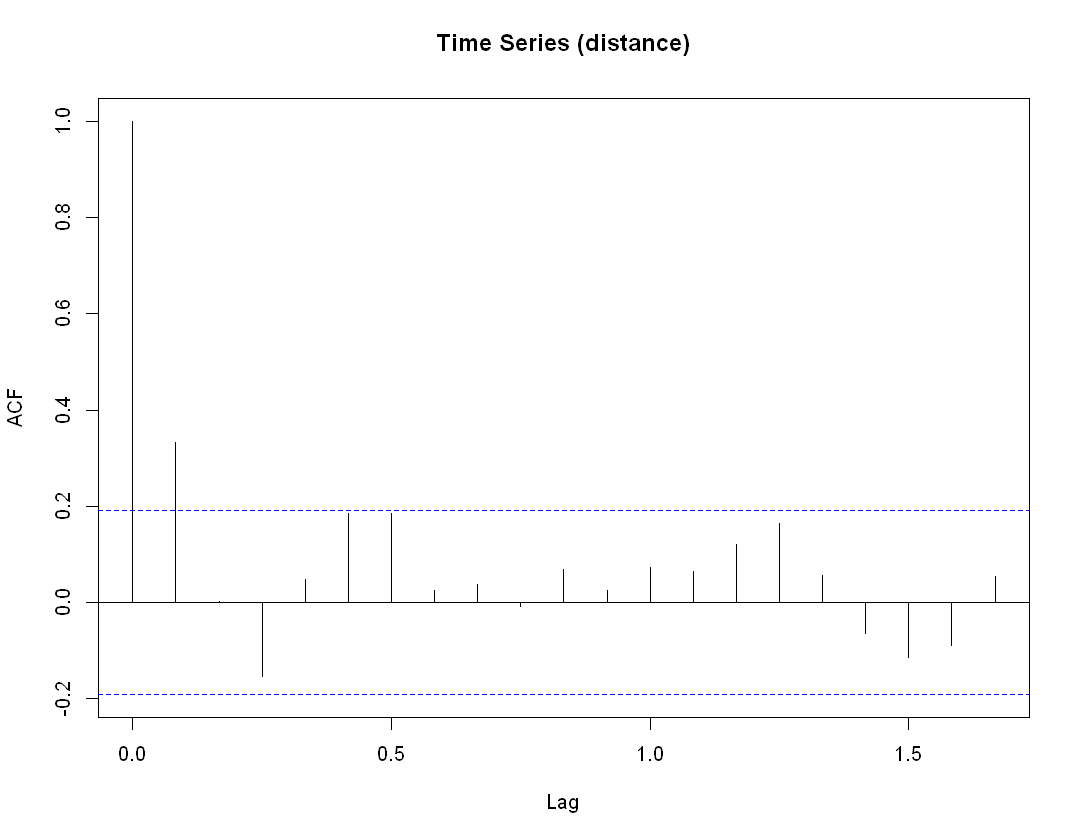

In [22]:
# Create a time series object from distance data
ts1 <- ts(ts_run$distance, start=c(2012, 1), frequency=12)

# Create a function to define figure size when plotting
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}

# Compute and plot the ACF for distance
fig(9,7)
acf(ts1, plot=T, main = "Time Series (distance)")

As we can check from the above graph we have a correlation coefficient of 0.33 for the first lag which means that the distance of the current month is positively correlated with the distance of the previous month (but not strongly). If we consider two lags, i.e., two months from the current, this correlation disappears. Let's see if there are any trends and seasonal patterns.

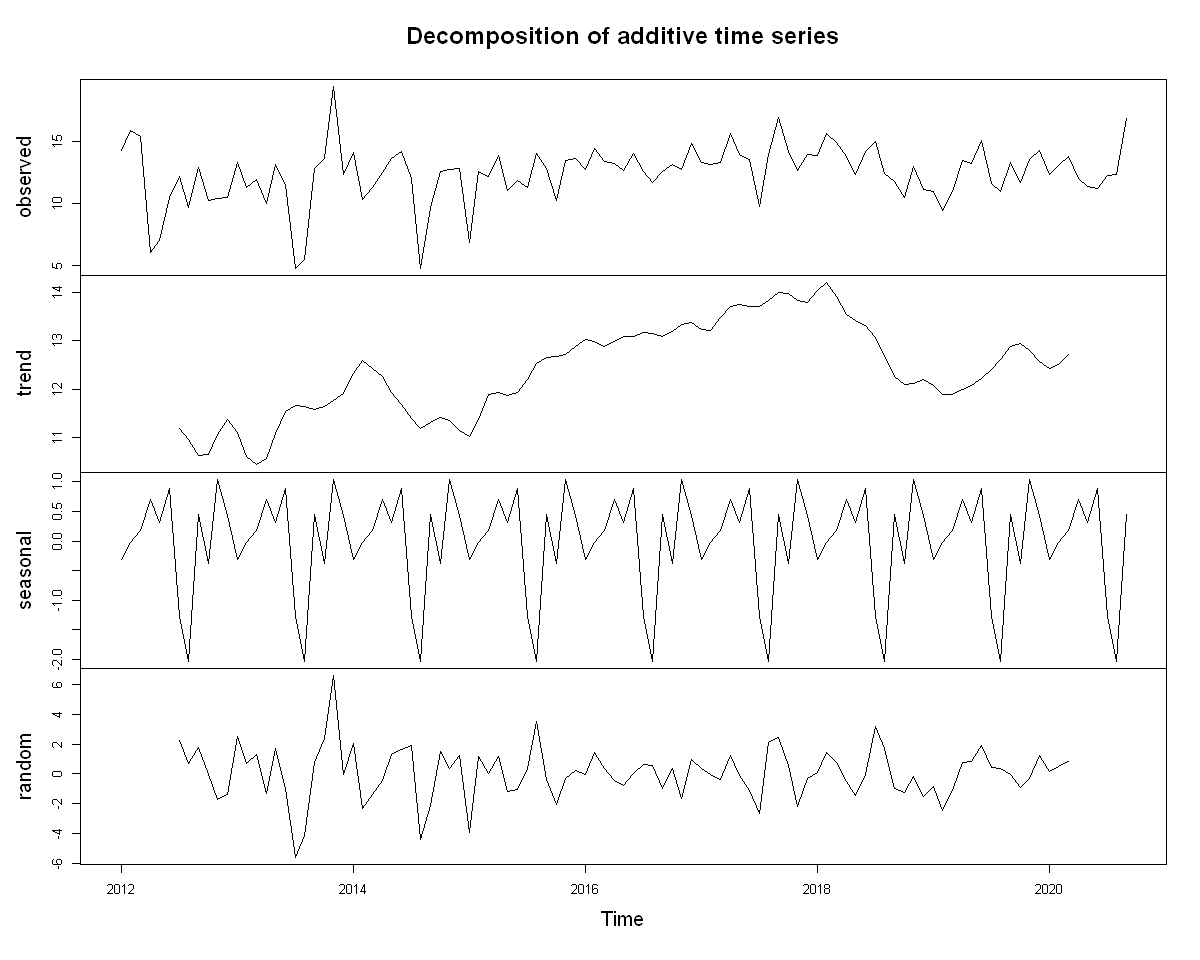

In [23]:
# Decompose distance time series and plot the result
fig(10,8)
plot(decompose(ts1))

From the previous graph we can check that there is an upward trend until 2017 that reverted during 2018/2019. From the seasonal part of the graph, there is an explicit pattern and residuals seems random that conforms with an additive time series. Let's check the others.

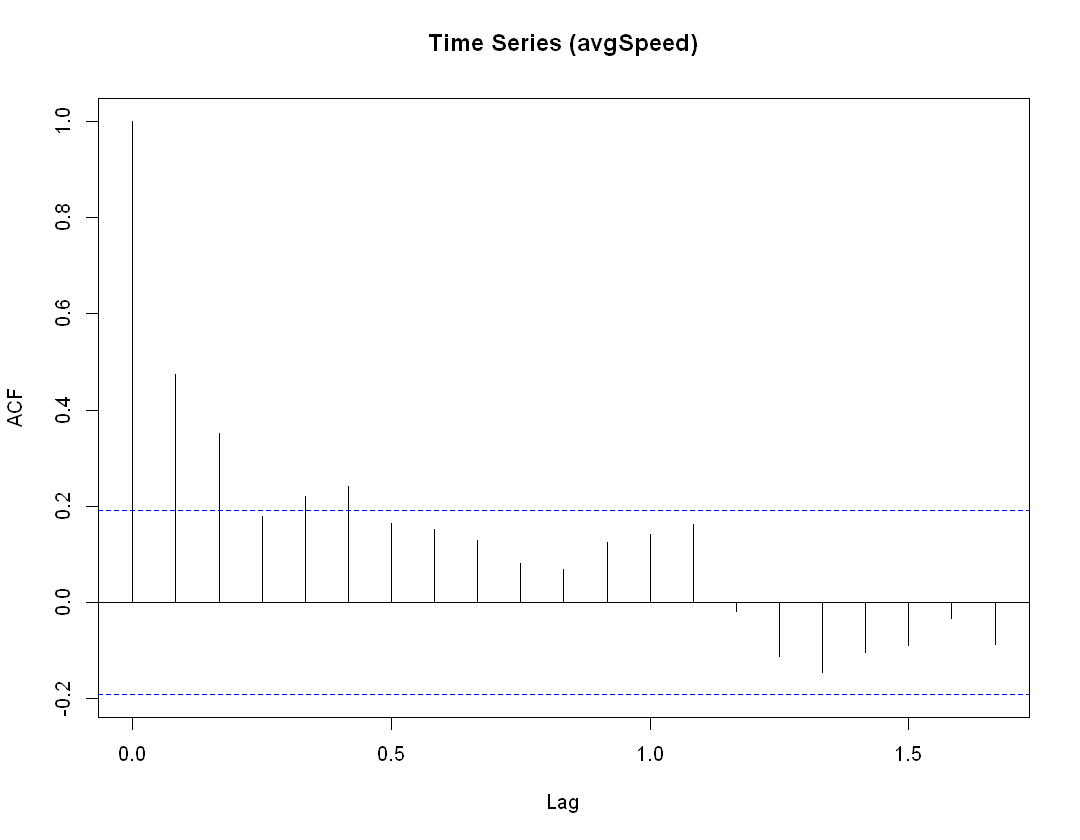

In [124]:
# Create a time series object from avgSpeed data
ts2 <- ts(ts_run$avgSpeed, start=c(2012, 1), frequency=12)

# Compute and plot the ACF for avgSpeed
fig(9,7)
acf(ts2, plot=T, main = "Time Series (avgSpeed)")

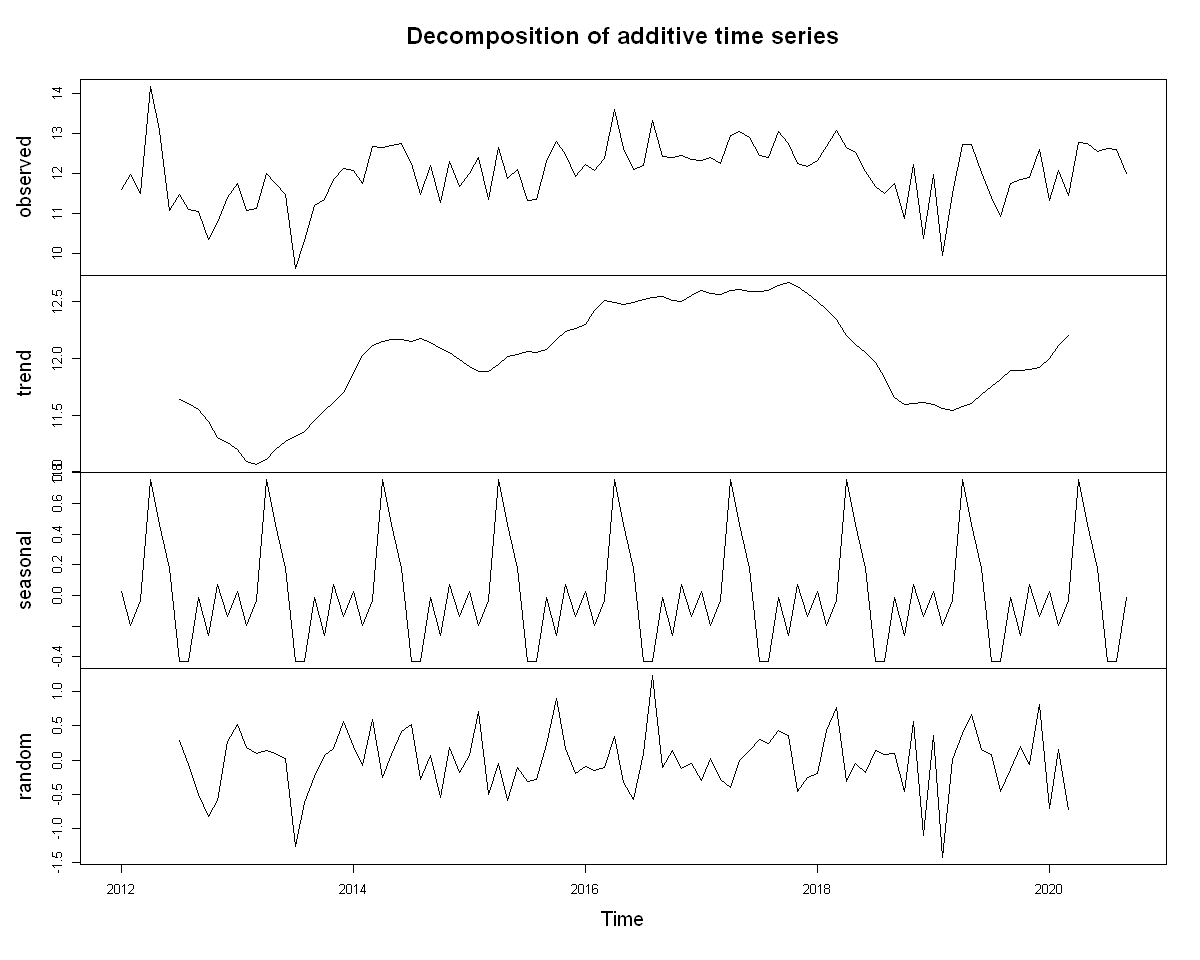

In [85]:
# Decompose avgSpeed time series and plot the result
fig(10,8)
plot(decompose(ts2))

We can check that there is an upward trend similar to the distance until 2017 that reverted during 2018/2019 before starting to increase again. The seasonal part of the graph shows an explicit pattern. Residuals seem also to be random. Let's continue.

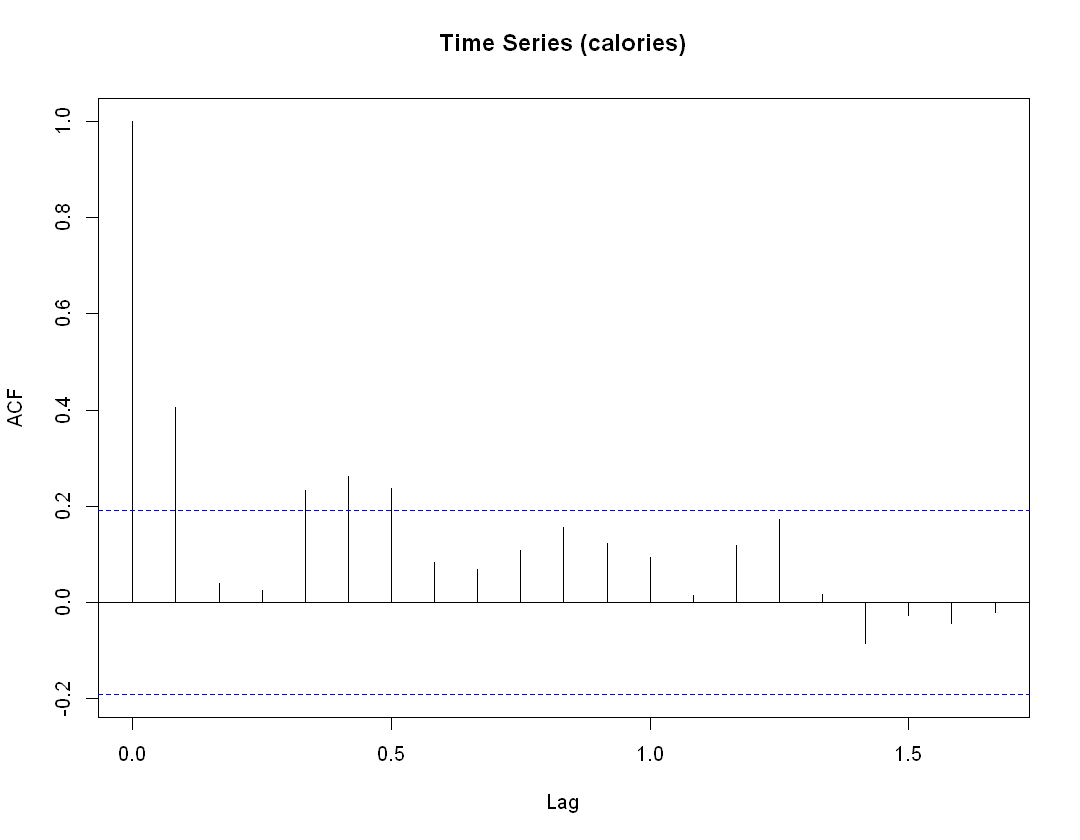

In [129]:
# Create a time series object from calories data
ts3 <- ts(ts_run$calories, start=c(2012, 1), frequency=12)

# Compute and plot the ACF for calories
fig(9,7)
acf(ts3, plot=T, main = "Time Series (calories)")

Calories are positively correlated with the intensity decreasing over time. Starting with a 0.4 coefficient for the first lag, then decreasing substantially for the second and third lag, increasing after, and so on. Let's check on trend and seasonal patterns.

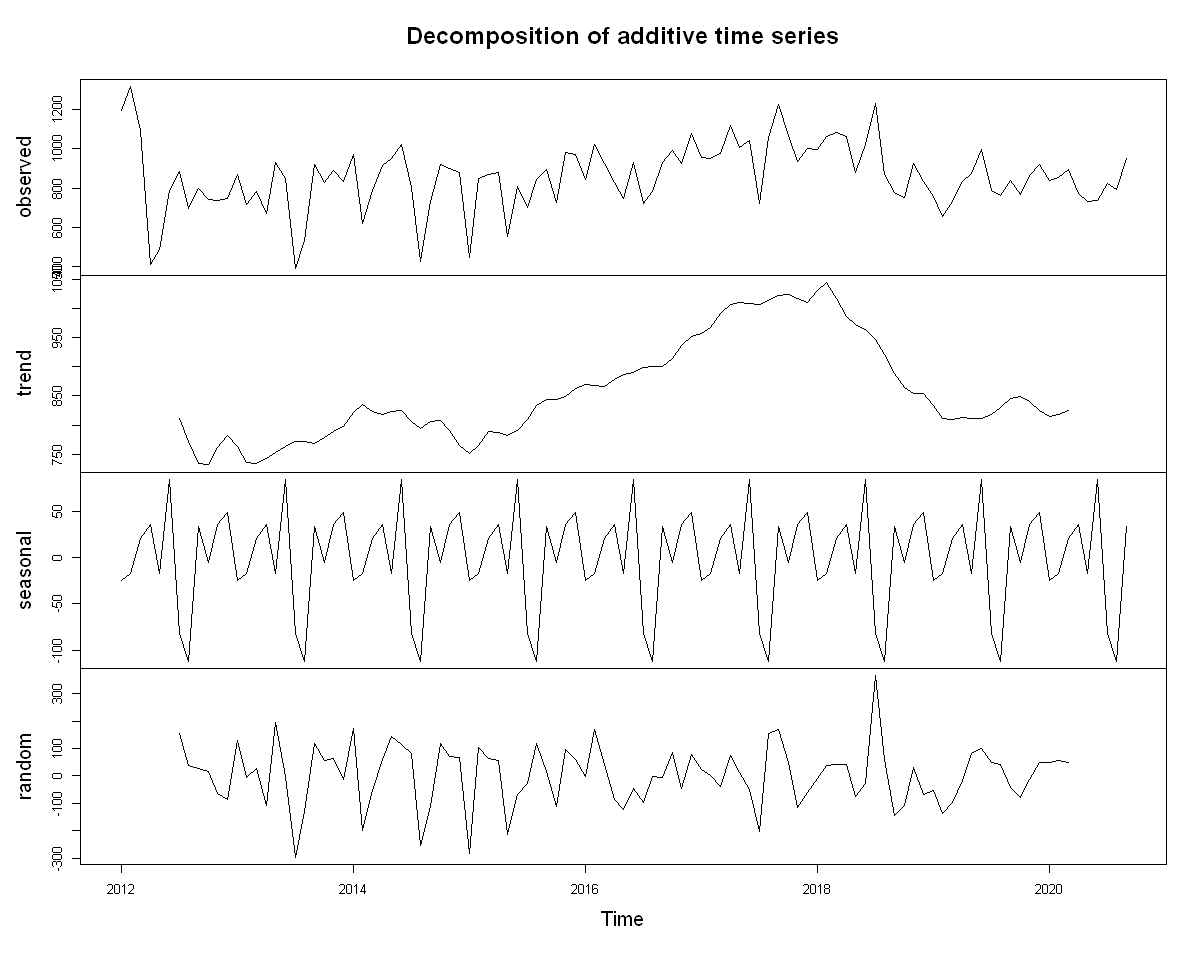

In [83]:
# Decompose calories time series and plot the result
fig(10,8)
plot(decompose(ts3))

Very similar to the previous series, calories seem to have an upward trend from the beginning of the observations until 2017, when it went downward and stabilized. There is an explicit seasonal pattern. Regarding the residuals, it seems to be have a pattern during 2015 which indicates that the decomposition may be multiplicative and not additive. Finally, let's analyze the average heart rate data. 

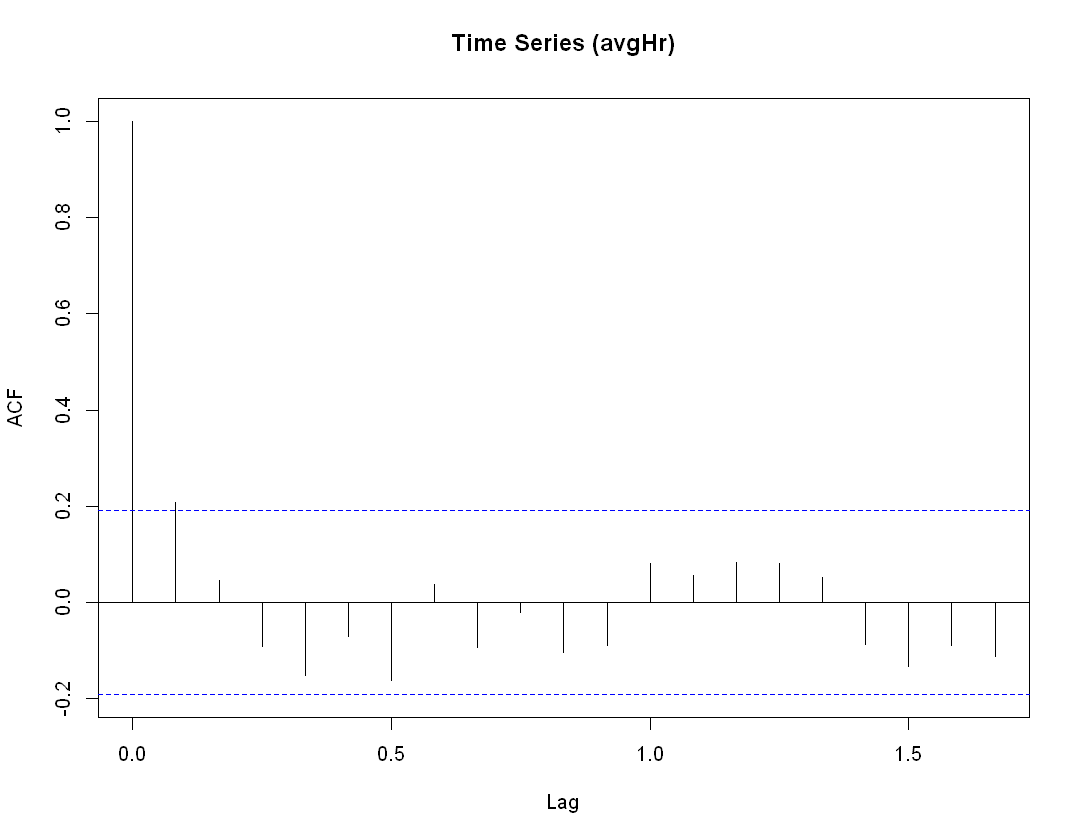

In [131]:
# Create a time series object from avgHr data
ts4 <- ts(ts_run$avgHr, start=c(2012, 1), frequency=12)

# Compute and plot the ACF for avgHr
fig(9,7)
acf(ts4, plot=T, main = "Time Series (avgHr)")

The average heart rate is also positively correlated with the intensity decreasing over time. Starting with a 0.2 coefficient for the first lag, then decreasing substantially for the second lag, and becoming negatively correlated afterward for lags 3 to 6. Let's check now on trend and seasonal patterns.

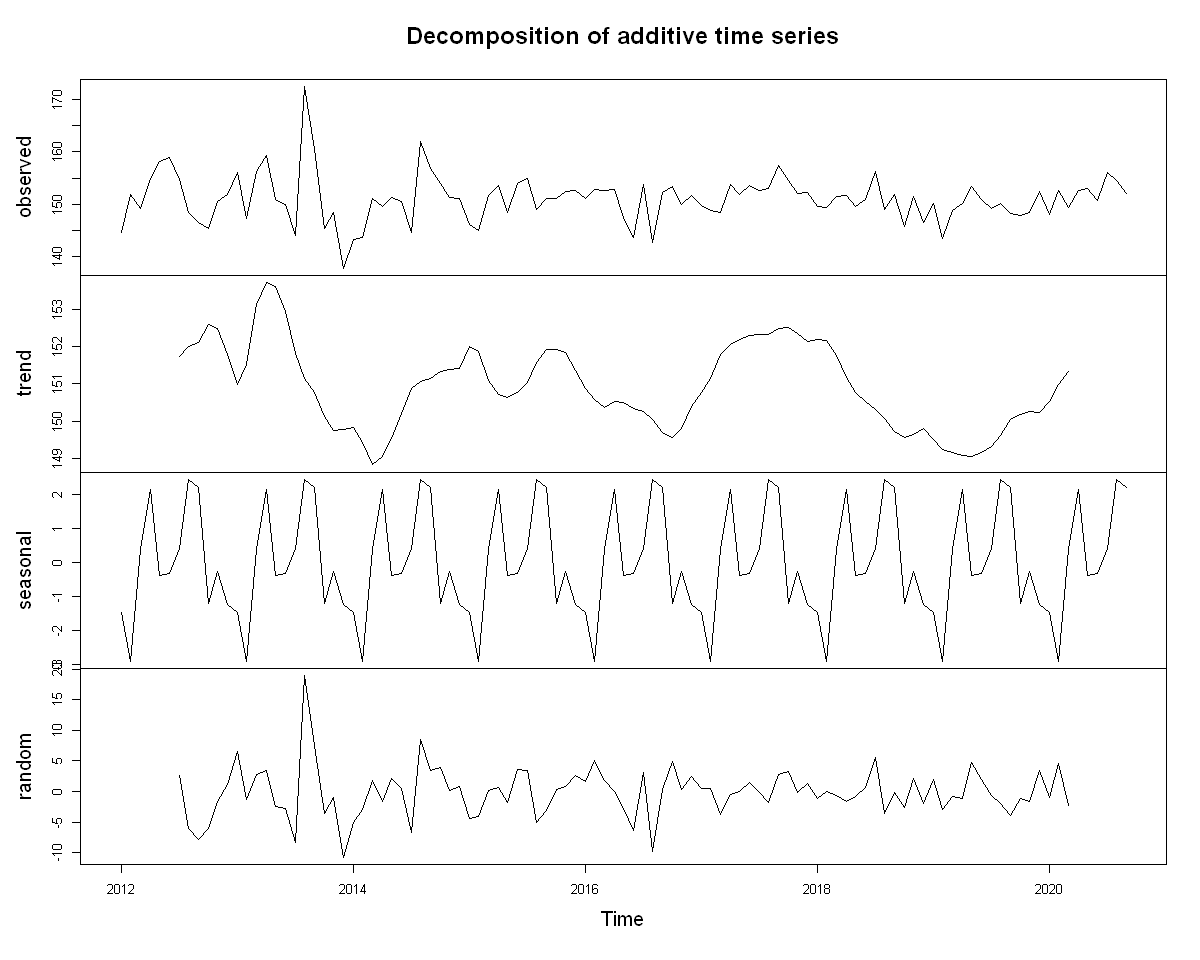

In [84]:
# Decompose avgHr time series and plot the result
fig(10,8)
plot(decompose(ts4))

This time, there is no identifiable trend for the average heart rate. Though, the time series is seasonal. About the residuals, they seem to be random which is conformed with an additive decomposition.

## Prediction

Now let's do some predictions using econometrics models. To start, we divide our data into train and test datasets.

In [53]:
# Divide data into train and test subsets
ts1_train <- window(ts1, start = c(2012,1), end = c(2018,12))
ts1_test <- window(ts1, start = c(2019,1))

### Naive method

When doing a forecast is always a good idea to have a base case to compare with. This tends to ensure that efforts are worthwhile in terms of results in a more complex model. For such we will use the seasonal naive method in which the forecast for the next month is what we observed from the same month a year before. As a comparison metric, we will use the mean absolute percentage error (MAPE).

In [65]:
# Run the seasonal naive model and compute the MAPE
naive <- snaive(ts1_train, h=length(ts1_test))
MAPE(naive$mean, ts1_test) * 100

[1] 17.91816

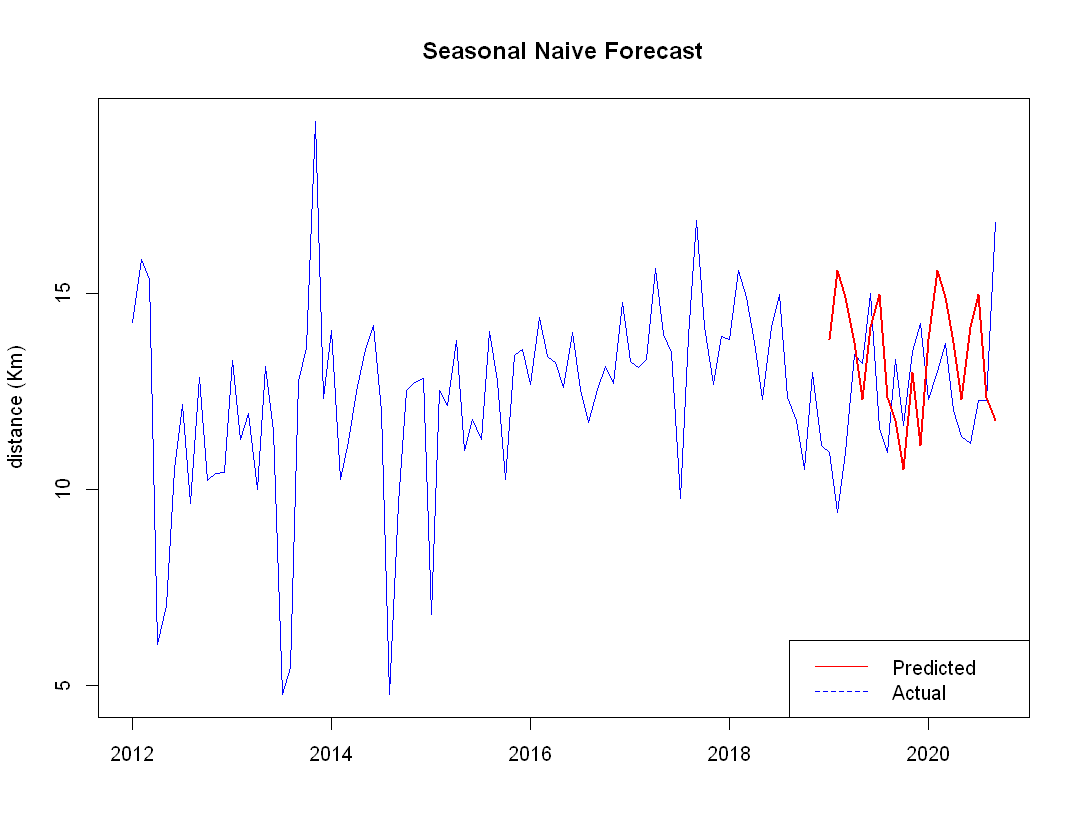

In [84]:
# Plot the results
fig(9,7)
plot(ts1, col="blue", xlab="", ylab="distance (Km)", main="Seasonal Naive Forecast", type='l')
lines(naive$mean, col="red", lwd=2)
legend("bottomright", legend=c("Predicted", "Actual"),
       col=c("red", "blue"), lty=1:2, cex=1)

This is our base to compare with other models. Let's see if we can improve our predictions.

### Double Seasonal Holt-Winters

The idea behind the Double Seasonal Holt-Winters model is the more recent an observation, more importance it will have in our forecast. This is done with the use of weights. There are also parameters regarding trend and seasonality.

In [116]:
# Run the Double Seasonal Holt-Winters model and compute the MAPE
dshw_model <- dshw(ts1_train, period1=4, period2 = 12, h=length(ts1_test))
MAPE(dshw_model$mean, ts1_test)*100

[1] 11.69182

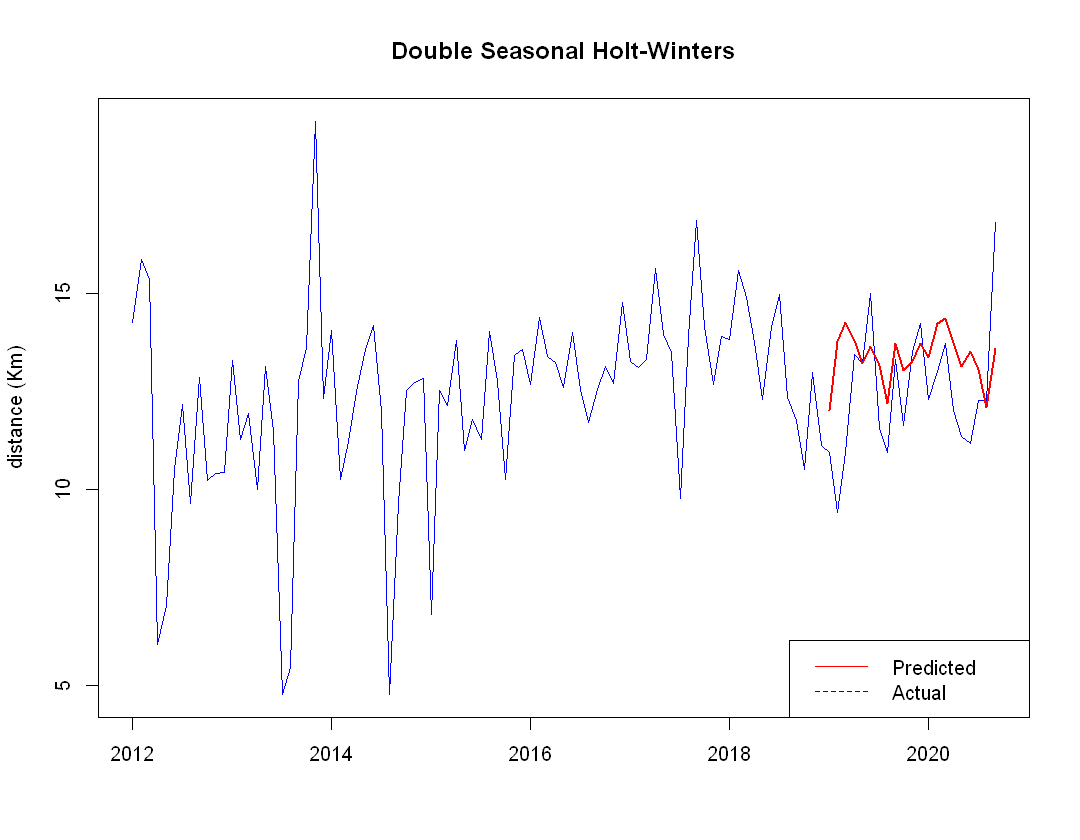

In [117]:
# Plot the results
fig(9,7)
plot(ts1, col="blue", xlab="", ylab="distance (Km)", main="Double Seasonal Holt-Winters", type='l')
lines(dshw_model$mean, col="red", lwd=2)
legend("bottomright", legend=c("Predicted", "Actual"),
       col=c("red", "blue"), lty=1:2, cex=1)

As per the above results, our prediction power improved compared to the base model. Let's continue.

### ARIMA

ARIMA models are very popular to perform predictions on time series. It is composed of three parts: autoregressive (parameter _p_), differencing (parameter _d_), and moving average (parameter _q_).

R provides a function to optimize these parameters called _auto.arima_. Let's use it.

In [176]:
# Estimate the ARIMA parameters
arima_model <- auto.arima(ts1_train); print(arima_model)

Series: ts1_train 
ARIMA(3,1,1) 

Coefficients:
         ar1      ar2      ar3      ma1
      0.2112  -0.1559  -0.3084  -0.8730
s.e.  0.1189   0.1095   0.1197   0.0738

sigma^2 estimated as 5.124:  log likelihood=-184.61
AIC=379.23   AICc=380.01   BIC=391.32


In [177]:
# Run the ARIMA model and compute the MAPE
fcast <- forecast(arima_model,h=length(ts1_test))
MAPE(fcast$mean, ts1_test)*100

[1] 12.11013

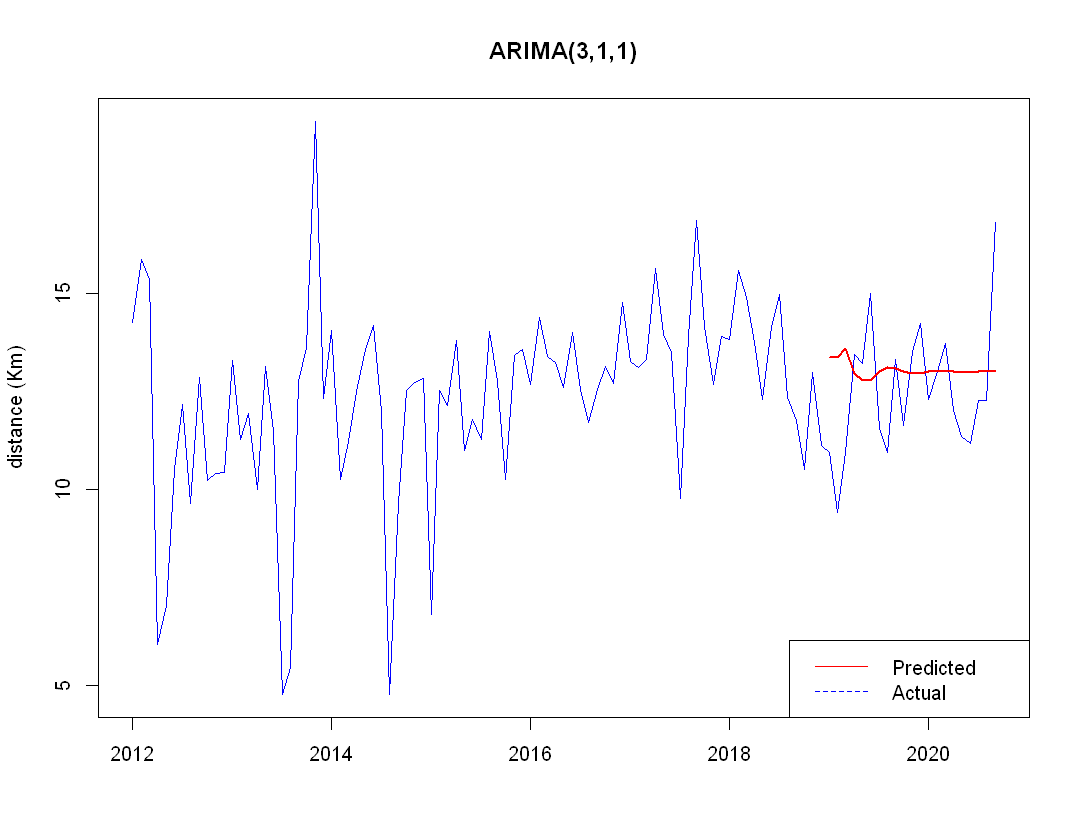

In [178]:
# Plot the results
fig(9,7)
plot(ts1, col="blue", xlab="", ylab="distance (Km)", main="ARIMA(3,1,1)", type='l')
lines(fcast$mean, col="red", lwd=2)
legend("bottomright", legend=c("Predicted", "Actual"),
       col=c("red", "blue"), lty=1:2, cex=1)

As we can see, the ARIMA model is quite conservative when performing predictions 21 steps (months) ahead. It worked quite similar to a linear regression where the goal is to minimize the square of the errors.

Let's try something different. Instead of forecasting the whole period, let's do it step by step and also incorporate new observations for each new prediction. This is a common procedure when dealing with time times since as time passes new information becomes available.

In [234]:
# Compute one step ahead forecast using ARIMA 
one_step_ahead_arima <- matrix(ncol = 2, nrow = 21)

for (i in 1:21){
        
    training_observed <- window(ts1, start = c(2012,1), end = c(2018,(12+i)), frequency = 12)
    
    arima_model <- auto.arima(training_observed) 
  
    forecast_arima = forecast(arima_model,h=1)
      
    forecasted = forecast_arima$mean
    observed = ts1_test[[i]]
  
    one_step_ahead_arima[i,1]= observed
    one_step_ahead_arima[i,2]= forecasted
}

MAPE(one_step_ahead_arima[,1], one_step_ahead_arima[,2]) * 100

[1] 7.456429

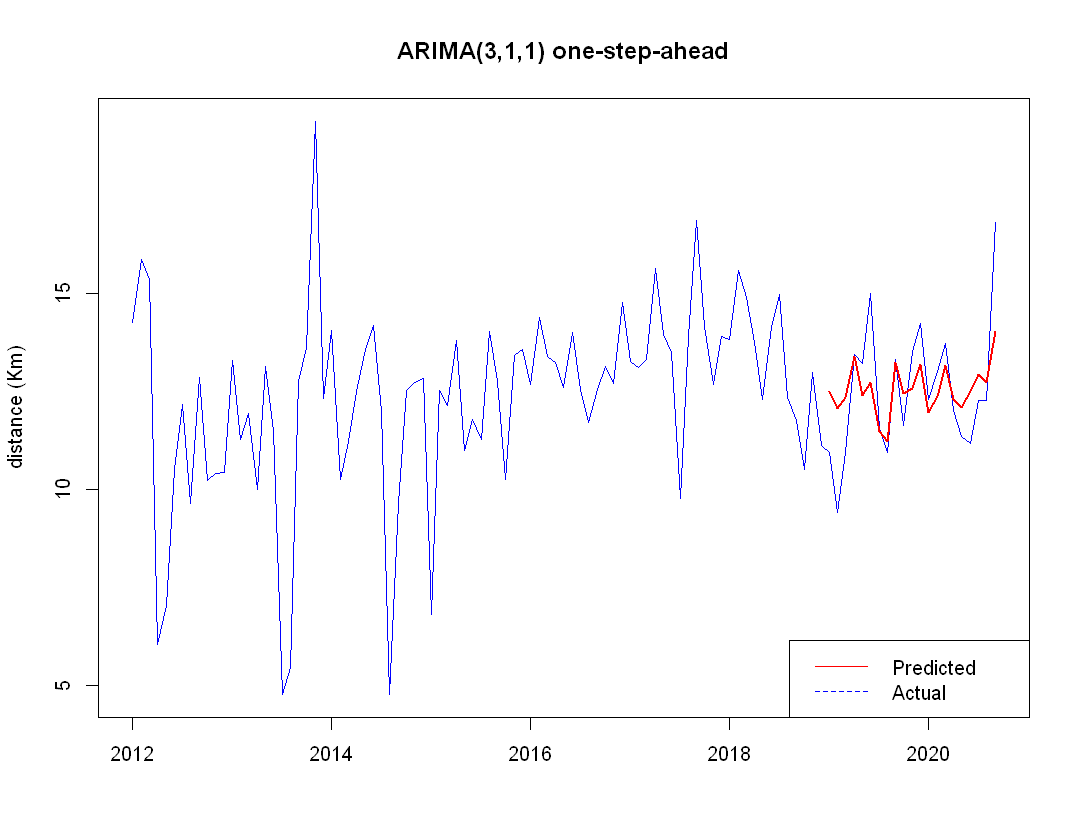

In [235]:
# Plot the results
fig(9,7)
plot(ts1, col="blue", xlab="", ylab="distance (Km)", main="ARIMA(3,1,1) one-step-ahead", type='l')
lines(ts(one_step_ahead_arima[,2], start = c(2019,1), frequency = 12), col="red", lwd=2)
legend("bottomright", legend=c("Predicted", "Actual"),
       col=c("red", "blue"), lty=1:2, cex=1)

As saw from the results, our prediction power increased significantly. The ARIMA model predicting one step and incorporating a new observation for each new prediction is the best model so far. 

Let's then use these three models on the other features.

In [356]:
# Divide dataset into train and test subsets
myTS <- lapply( paste0('ts',1:4), get)

for(i in 1:4) { 
    train <- paste(c("ts", i,'_train'), collapse = "")
    test <- paste(c("ts", i,'_test'), collapse = "")
    assign(train, window(myTS[[i]], start = c(2012,1), end = c(2018,12)))
    assign(test, window(myTS[[i]], start = c(2019,1)))
    
}

In [360]:
# Create one-step-ahead ARIMA function
arima1step <- function(ts, test) {
    
   one_step_ahead_arima <- matrix(ncol = 2, nrow = 21)

    for (i in 1:21){

        training_observed <- window(ts, start = c(2012,1), end = c(2018,(12+i)), frequency = 12)

        arima_model <- auto.arima(training_observed) 

        forecast_arima = forecast(arima_model,h=1)

        forecasted = forecast_arima$mean
        observed = ts1_test[[i]]

        one_step_ahead_arima[i,1]= observed
        one_step_ahead_arima[i,2]= forecasted
    }

    return(one_step_ahead_arima)
}


# Run the models
train <- lapply( paste0('ts',1:4,'_train'), get)
test <- lapply( paste0('ts',1:4,'_test'), get)

for(i in 1:1) { 
    naive <- paste(c("naive",'_ts', i), collapse = "")
    dshw <- paste(c("dshw", '_ts', i), collapse = "")
    arima <- paste(c("arima", '_ts', i), collapse = "")
    assign(naive, snaive(train[[i]], h=length(test[[i]])))
    assign(dshw, dshw(train[[i]], period1=4, period2 = 12, h=length(test[[i]])))
    assign(arima, arima1step(myTS[[i]],test[[i]]))
}

In [384]:
# Compute the MAPE for each model
naive_mod <- lapply( paste0('naive_ts',1:4), get)
dshw_mod <- lapply( paste0('dshw_ts',1:4), get)
arima_mod <- lapply( paste0('arima_ts',1:4), get)

for(i in 1:4) { 
    mapeNaive <- paste(c("naive_mape",'_ts', i), collapse = "")
    mapeDshw <- paste(c("dshw_mape", '_ts', i), collapse = "")
    mapeArima <- paste(c("arima_mape", '_ts', i), collapse = "")
    assign(mapeNaive, MAPE(naive_mod[[i]]$mean, test[[i]]) * 100)
    assign(mapeDshw, MAPE(dshw_mod[[i]]$mean, test[[i]])*100)
    assign(mapeArima, MAPE(arima_mod[[i]][,1], arima_mod[[i]][,2]) * 100)
}

In [395]:
# Create a table of results
results <- matrix(c(naive_mape_ts1,naive_mape_ts2,naive_mape_ts3,naive_mape_ts4,dshw_mape_ts1,dshw_mape_ts2,
                    dshw_mape_ts3,dshw_mape_ts4,arima_mape_ts1,arima_mape_ts2,arima_mape_ts3,arima_mape_ts4),
                    ncol=4,byrow=TRUE)
colnames(results) <- c("distance","avgSpeed","calories","avgHr")
rownames(results) <- c("Naive","DSWH","ARIMA")
results <- as.table(results)
print(results)

       distance  avgSpeed  calories     avgHr
Naive 17.918156  6.482069 24.065333  1.734363
DSWH  11.691823  4.537593 14.995613  1.629470
ARIMA  7.456429 10.546566 98.481339 91.694661


Interestingly, the best performer for the other features was the Double Seasonal Holt-Winters model. The ARIMA model was the poorest model by large on these new features. Worth of notice was the performance of the best model for average heart rate (not very far from the naive model).

## Conclusion

In this task, we performed data preparation, visualization, and prediction using time series. During the preparation step, we selected only the numerical features (a time series prerequisite) and used the features with the least number of missing values. To understand the data we used some econometrics tools like creating ACF plots and decomposing the series for analysis. Then we used three different methods to model each time series and checked the results.

For most of the features, the best performing model was the Double Seasonal Holt-Winters. It seems that it captured better than the other models the trend and seasonal patterns present in those series. The ARIMA model performed well for just one feature (distance) and poorly with the others. For parameters choosing (in the case of ARIMA), we used the ones suggested by Auto ARIMA and did not delve deeper into the decomposition of the series for fine-tuning them.